In [3]:
import pandas as pd
import numpy as np
import pyodbc
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import stats
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 6]

## Video Players Analysis

Two video players were evaluated based on a rate metric calculated from a binary variable. The goal was to determine if switching to the newer player led to better performance without disturbing network quality.

In [14]:
### Sample data - each row represents one event
df1.head()

,network_quality,metric
0,58,0
1,71,1
2,60,1
3,65,1
4,62,1


In [6]:
### Function to calculate metric value in each 5-unit bin
def binAvg(df):
    metric = []
    for bin_edge in range(20, 105, 5):
        metric.append(df[(df['network_quality'] >= bin_edge) & (df['network_quality'] < bin_edge + 5)]['metric'].mean())
        
    df_out = pd.DataFrame({'network_quality': range(20, 105, 5), 'metric': metric})
            
    return(df_out[['network_quality', 'metric']])

In [7]:
def plotMetric(df_orig1, df_orig2):
    df1 = binAvg(df_orig1).sort_values('network_quality')
    df2 = binAvg(df_orig2).sort_values('network_quality')
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(df1['network_quality'], df1['metric'], '-o')
    ax1.plot(df2['network_quality'], df2['metric'], '-o')
    ax2 = ax1.twinx()
    ax2.hist(
        [df_orig1['network_quality'], df_orig2['network_quality']], 
        bins=16, 
        normed=True, 
        alpha=.4, 
        edgecolor='k'
    )
    ax1.legend(['Version 1', 'Version 2'], fontsize=12)
    ax1.set_xlabel('Network Quality', fontsize=15)
    ax1.set_ylabel('Metric Value', fontsize=15)
    ax1.set_title('Metric Value Distribution by Network Quality', fontsize=15)  
    ax1.set_xlim(15, 105)
    ax2.set_ylabel('Relative Frequency', fontsize=15)

A dual Y-axis plot was used, with a line plot showing metric value overlaid on a histogram of tests in 5-unit bins. Sample size is comparable between the 2 versions. 

The plot aims to tell the following story:
* Switching from Version 1 to Version 2 does not have a material impact on the distribution of network quality.
* Version 2 outperforms Version 1 at every level, especially under poor network quality conditions.
* Version 2 significantly outperforms Version 1 where the bulk of events take place, i.e. between 45 and 70 in network quality.

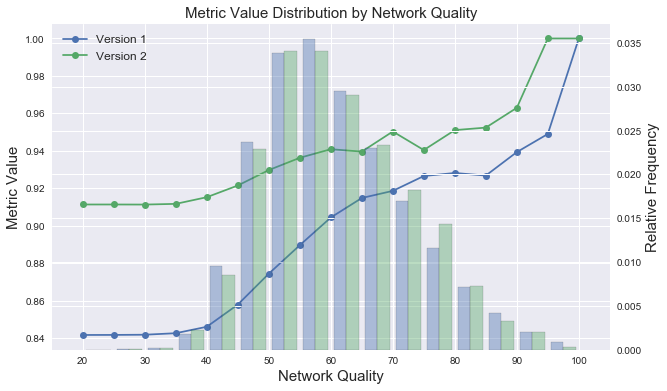

In [20]:
plotMetric(df1, df2)

Based on the visualization, a recommendation was made to retire Version 1.

## App Usage by Hour

The following plot shows the average data usage per user of a certain app by hour in 38 markets. Markets are ranked and colored by average usage across all hours. The goal is to examine usage variation across the day and possible differences in pattern between high-usage and low-usage markets.

In [5]:
### Sample data
df.head()

,market,hour,avg_usage,market_rank
0,25,12,1.644958,12
1,25,2,2.106267,12
2,25,17,2.098361,12
3,25,22,2.450721,12
4,25,11,1.503632,12


C:\Users\carlw\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


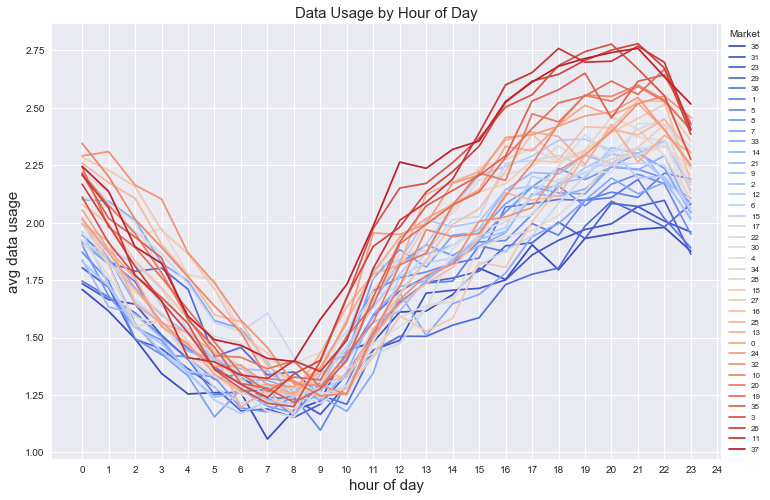

In [16]:
num_colors = len(set(df['market']))
fig, ax = plt.subplots(figsize=(12, 8))
cm = plt.get_cmap('coolwarm')
ax.set_color_cycle([cm(1.*i/num_colors) for i in range(num_colors)])
for rank in range(num_colors-1, -1, -1):
    df_temp = df[df['market_rank'] == rank].sort_values(by='hour').reset_index(drop=True)
    ax.plot(df_temp['hour'], df_temp['avg_usage'], '-', label=df_temp['market'][0])
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', title='Market', fontsize=8)
ax.set_xlabel('hour of day', fontsize=15)
ax.set_ylabel('avg data usage', fontsize=15)
ax.set_title('Data Usage by Hour of Day', fontsize=15)
ticks = ax.set_xticks(range(0, 25))

While there is clearly hourly variation overall, it seems that all markets follow the same pattern, with usage picking up after 9am and dropping off around bedtime. The difference in usage seems to be minimal during early morning, i.e. roughly between 6am and 9am.

## Video & Data Transfer Events Alignment

Given a data set containing 2 types of records--video events and app data transfer events--a function was written to align them visually by timestamp to see if the events overlap completely.

In [132]:
### Sample data
df.head()

,instanceid,type,starttimestamp,endtimestamp,dl_speed
0,1,SD,2018-10-23 13:55:59,2018-10-23 13:56:04,NaN
1,1,LD,2018-10-23 13:55:56,2018-10-23 13:55:59,NaN
2,1,SD,2018-10-23 13:56:44,2018-10-23 13:56:47,NaN
3,1,SD,2018-10-23 13:56:04,2018-10-23 13:56:44,NaN
4,1,App,2018-10-23 13:55:46,2018-10-23 13:55:54,1.996643


In [133]:
def plot_data_transfer(data):
    
    temp = data.copy()
    
    # Bar Dimensions
    temp['startsec'] = (temp['starttimestamp'] - temp[temp['type'] != 'App']['starttimestamp'].min()) / pd.Timedelta(seconds=1)
    temp['totalsec'] = (temp['endtimestamp'] - temp['starttimestamp']) / pd.Timedelta(seconds=1)
    temp['height'] = temp['dl_speed'].fillna(1.5 * temp['dl_speed'].max())

    # Plot Test Blocks
    colors = {'HD': (0, 1, 0), 'SD': (0, 0.75, 0), 'LD': (0, 0.5, 0), 'Stall': 'black', 'Set-up': 'silver'}
    label_count = {'HD': 0, 'SD': 0, 'LD': 0, 'Stall': 0, 'Set-up': 0, 'App': 0}  # Create count of each label to avoid duplicate legends
    for index, row in temp[temp['type'] != 'App'].iterrows():
        plt.bar(
            left=float(row['startsec']),
            height=float(row['height']),
            width=float(row['totalsec']),
            align='edge',
            label=row['type'] if label_count[row['type']] == 0 else "",
            color=colors[row['type']],
            linewidth=0
        )
        label_count[row['type']] = label_count.get(row['type'], 0) + 1

    # Plot App Throughput Events
    for index, row in temp[temp['type'] == 'App'].iterrows(): 
        plt.bar(
            left=float(row['startsec']),
            height=float(row['height']),
            width=float(row['totalsec']),
            align='edge',
            label='App' if label_count['App'] == 0 else "",
            color='white',
            edgecolor='black',
            linewidth=1,
            alpha=0.75
        )
        label_count[row['type']] = label_count.get(row['type'], 0) + 1

    plt.ylim(ymax=temp['height'].max())
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    plt.xlabel('Seconds', fontsize=15)
    plt.ylabel('Download Speed', fontsize=15)
    plt.title('Test: ' + str(temp['instanceid'].iloc[0]), fontsize=15)

Here's an example of a **complete mapping**. Each top bar represents a video event colored by type (HD, SD, LD, Stall Event or Set-up Event). Each bottom bar represents a data transfer event, with height representing the speed of transfer and area representing total data transferred.

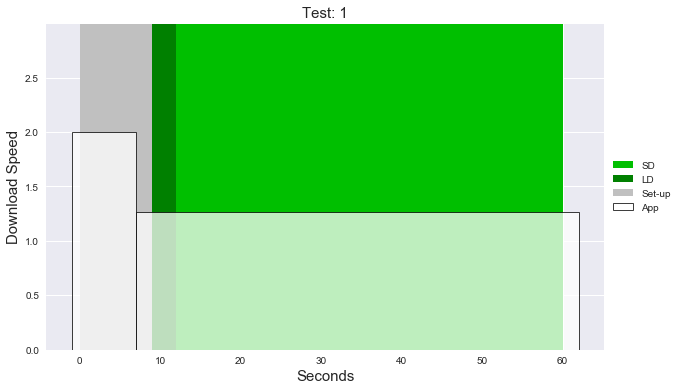

In [135]:
plot_data_transfer(df[df['instanceid'] == 1])

Here's an example of an **incomplete mapping**. Notice that the bottom bars do not fully cover the beginning and end of the
video events.

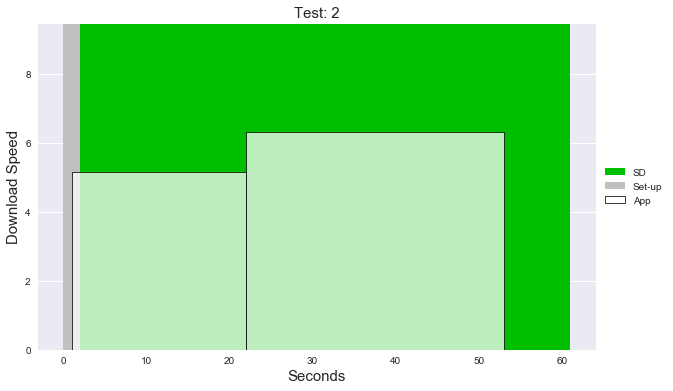

In [136]:
plot_data_transfer(df[df['instanceid'] == 2])

## Performance Improvement Analysis

The following plot was created to help the team determine a cutoff threshold to filter out low-usage apps in order to reduce the size of our app-level data table.

In [11]:
# Sample data - the filter is in .1 second increments
df_floors.head()

,floor,pct_records_eliminated,pct_usage_preserved
0,0.00,0.000000,1.000000
0,0.10,0.131617,0.994902
0,0.20,0.177320,0.990803
0,0.31,0.204705,0.987256
0,0.41,0.234352,0.983687


Text(8,0.45,'48%')

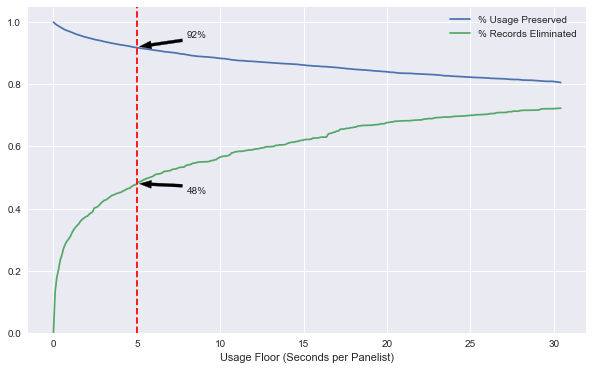

In [13]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(df_floors['floor'], df_floors['pct_usage_preserved'])
ax.plot(df_floors['floor'], df_floors['pct_records_eliminated'])
ax.set_ylim(ymin=0)
ax.set_xlabel('Usage Floor (Seconds per Panelist)')
ax.legend(['% Usage Preserved', '% Records Eliminated'])
plt.axvline(x=5, color='r', linestyle='--')
ax.annotate('92%', xy=(5, .92), xytext=(8, .95), arrowprops=dict(facecolor='black', width=3, headwidth=8, shrink=0.05))
ax.annotate('48%', xy=(5, .48), xytext=(8, .45), arrowprops=dict(facecolor='black', width=3, headwidth=8, shrink=0.05))

The plot tells us that if we exclude all apps that average less than 5 seconds of usage per panelist, we can get rid of half the records in this table and still preserve 92% of all the usage info. 

## Effect of Software Update on Metric

The plot looks at how a software update in a mobile device (indicated by the dashed line) affected the values of a metric in 4 markets during subsequent weeks.

In [24]:
### sample data
df.head()

,market,week,metric
0,4,2018-06-11,0.924846
1,3,2018-05-14,0.974751
2,2,2018-02-26,0.950669
3,2,2018-05-21,0.929668
4,2,2018-05-14,0.958554


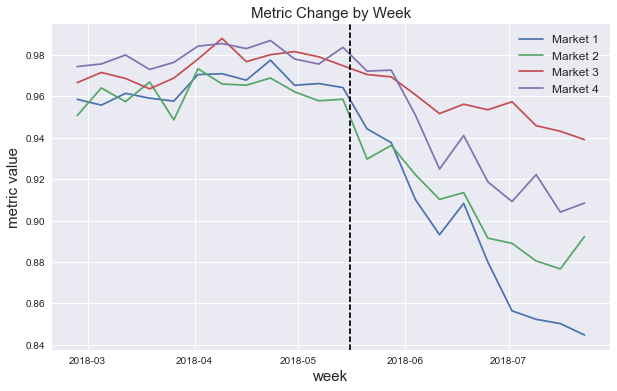

In [111]:
for market in range(1, 5):
    df_temp = df[df['market'] == market].sort_values('week').reset_index(drop=True)
    plt.plot_date(df_temp['week'], df_temp['metric'], fmt='-')
plt.legend(['Market ' + str(market) for market in range(1, 5)], fontsize=12)
plt.xlabel('week', fontsize=15)
plt.ylabel('metric value', fontsize=15)
plt.title('Metric Change by Week', fontsize=15)
plt.setp(labels, rotation=45)
plt.axvline(x='2018-05-16', linestyle='dashed', color='black')

## Effect of Weighting on Metric Value

The following plot aims to examine how weighting affects the values of a metric across 4 markets.

In [155]:
### Sample data
df.head()

,market,month,metric,type
0,1,4,0.976,weighted
1,1,4,0.971,unweighted
2,1,5,0.972,weighted
3,1,5,0.974,unweighted
4,1,6,0.941,weighted


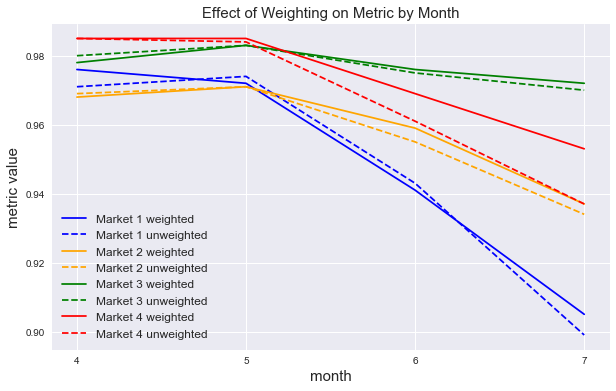

In [5]:
for market, color in enumerate(['blue', 'orange', 'green', 'red'], 1):
    df_weighted = df[(df['market'] == market) & (df['type'] == 'weighted')]
    df_unweighted = df[(df['market'] == market) & (df['type'] == 'unweighted')]
    plt.plot(df_weighted['month'], df_weighted['metric'], '-', c=color,  label='Market ' + str(market) + ' weighted')
    plt.plot(df_unweighted['month'], df_unweighted['metric'], '--', c=color,  label='Market ' + str(market) + ' unweighted')
plt.legend(fontsize=12)
plt.xlabel('month', fontsize=15)
plt.ylabel('metric value', fontsize=15)
plt.title('Effect of Weighting on Metric by Month', fontsize=15)
ticks = plt.xticks(range(min(df['month']), max(df['month'])+1))

One can see that Market 4 benefits from weighting the most.